In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import hnn_core
from hnn_core import calcium_model, simulate_dipole, read_params, pick_connection, jones_2009_model
from hnn_core.cells_default import _exp_g_at_dist, _linear_g_at_dist
from hnn_core.network_models import add_erp_drives_to_jones_model
from functools import partial
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm

--No graphics will be displayed.


### Create base network with standard ERP drives and new NMDA synapses

In [19]:
# l_contra_params = read_params('../data/L_Contra.param')
# net_base = calcium_model(params=l_contra_params, add_drives_from_params=True)
net_base = jones_2009_model()

net_base.add_connection(src_gids='L5_pyramidal', target_gids='L2_basket', receptor='nmda',
                        weight=0.0, delay=0.0, loc='soma', lamtha=3.0)

net_base.add_connection(src_gids='L5_pyramidal', target_gids='L5_basket', receptor='nmda',
                        weight=0.0, delay=0.0, loc='soma', lamtha=3.0)

net_base.add_connection(src_gids='L2_pyramidal', target_gids='L2_basket', receptor='nmda',
                        weight=0.0, delay=0.0, loc='soma', lamtha=3.0)

net_base.add_connection(src_gids='L2_pyramidal', target_gids='L5_basket', receptor='nmda',
                        weight=0.0, delay=0.0, loc='soma', lamtha=3.0)


add_erp_drives_to_jones_model(net_base)

In [75]:
# Dendritic Km sweep
def L5_pyramidal_km_dend(net, scale=0.0):
    for sec_name, sec in net.cell_types['L5_pyramidal'].sections.items():
        if sec_name != 'soma':
            sec.mechs['km']['gbar_km'] *= (10 ** scale)


# Inhibitory gain sweep
def inhibitory_gain(net, scale=0.0):
    conn_indices = pick_connection(net, target_gids=['L2_basket', 'L5_basket'], receptor=['gabaa'])
    for conn_idx in conn_indices:
        net.connectivity[conn_idx]['nc_dict']['A_weight'] *= 10 ** scale

# Feedforward gain sweep
def feedforward_gain(net, scale=0.0):
    conn_indices = pick_connection(net, src_gids=['evprox1', 'evprox2'])
    for conn_idx in conn_indices:
        net.connectivity[conn_idx]['nc_dict']['A_weight'] *= 10 ** scale

# # NMDA conductance sweep
# def L2e_L5i_nmda(net, val=0.0):
#     conn_indices = pick_connection(net, src_gids='L2_pyramidal', target_gids='L5_basket', receptor='nmda')
#     for conn_idx in conn_indices:
#         net.connectivity[conn_idx]['nc_dict']['A_weight'] = 10 ** val



def run_simulation(net_base, theta_i, prior_dict):
    assert len(theta_i) == len(prior_dict)

    net = net_base.copy()
    for param_idx, param_name in enumerate(prior_dict.keys()):
        update_function = prior_dict[param_name]['update_function']
        update_function(net, theta_i[param_idx])

    dpl = simulate_dipole(net, tstop=tstop, dt=dt, n_trials=1)
    return dpl[0].copy().smooth(60).data['agg']


In [87]:
min_val, max_val = 0, 1

prior_dict = {
    # 'L2e_L5i_nmda': {'bounds': (min_val, max_val), 'update_function': L2e_L5i_nmda, 'mech_name': 'L2e->L5i NMDA'},
    'feedforward_gain': {'bounds': (min_val, max_val), 'update_function': feedforward_gain, 'mech_name': 'Feedforward gain'},
    'L5_pyramidal_km_dend': {'bounds': (min_val, max_val), 'update_function': L5_pyramidal_km_dend, 'mech_name': 'Dendritic Km'},
    'inhibitory_gain': {'bounds': (min_val, 1), 'update_function': inhibitory_gain, 'mech_name': 'GABA disinhibition'},

}

num_params = len(prior_dict)
sweep_len = 10

theta = np.zeros((num_params * sweep_len, num_params))
labels = list()
for param_idx, param_name in enumerate(prior_dict.keys()):
    min_val, max_val = prior_dict[param_name]['bounds']
    sweep_values = np.linspace(min_val, max_val, sweep_len)

    start_idx = param_idx * sweep_len
    stop_idx = start_idx + sweep_len
    theta[start_idx:stop_idx, param_idx] = sweep_values

    labels.extend(np.repeat(prior_dict[param_name]['mech_name'], sweep_len).tolist())


In [88]:
tstop = 200
dt = 0.025

res = Parallel(n_jobs=50)(delayed(run_simulation)(net_base, theta[idx,:], prior_dict) for idx in range(theta.shape[0]))


Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEU

In [89]:
df_dict = {
    'dpl': res,
    'label': labels,
    'theta': theta.tolist()}
df = pd.DataFrame(df_dict)

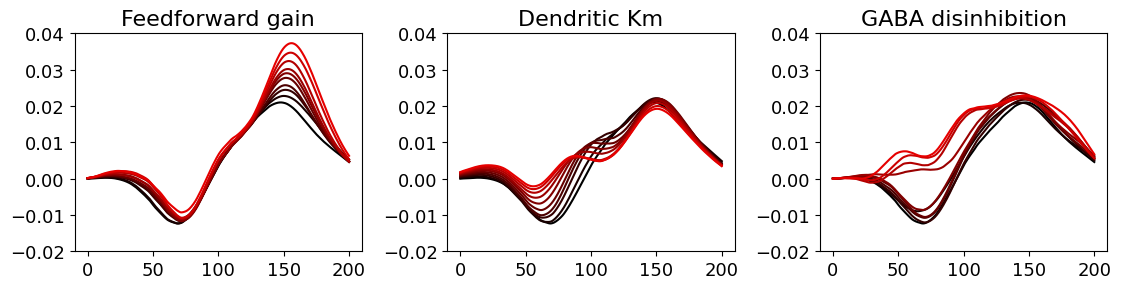

In [90]:
ticksize = 13
labelsize = 14
titlesize = 16

unique_labels = df['label'].unique()
times = np.linspace(0, tstop, len(res[0]))

plt.figure(figsize=(15,3))
for plot_idx, label_name in enumerate(unique_labels):

    cmap_color = 'r'
    colors = ['k', cmap_color] # first color is black, last is red
    cmap = LinearSegmentedColormap.from_list(
            "Custom", colors)

    plt.subplot(1, 4, plot_idx+1)
    mask = df['label'] == label_name
    dpl_data = df[mask]['dpl'].values

    for sim_idx in range(sweep_len):
        sweep_color = cmap(sim_idx / sweep_len)
        plt.plot(times, dpl_data[sim_idx], linewidth=1.5, color=sweep_color)

    plt.title(label_name, fontsize=titlesize)
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)

    plt.ylim(-0.02, 0.04)


plt.tight_layout()